== Missing spec
InVars: []
OutVars:[J1, J2]
A: [
  
]
G: [
  -3.2 J1 + 0.83 J2 <= -0.2
  3 J1 - 1.64 J2 <= -0.6
]
== Missing spec by hand
InVars: []
OutVars:[J1, J2]
A: [
  
]
G: [
  -3.2 J1 + 0.83 J2 <= -0.2
  3 J1 - 1.64 J2 <= -0.6
]
== Missing spec
InVars: []
OutVars:[J1, J2]
A: [
  
]
G: [
  0.018 J1 <= 0.1
  0.009 J2 <= 0.1
]
== Overall spec
InVars: []
OutVars:[J1, J2]
A: [
  
]
G: [
  0.018 J1 <= 0.1
  0.009 J2 <= 0.1
  -3.2 J1 + 0.83 J2 <= -0.2
  3 J1 - 1.64 J2 <= -0.6
]


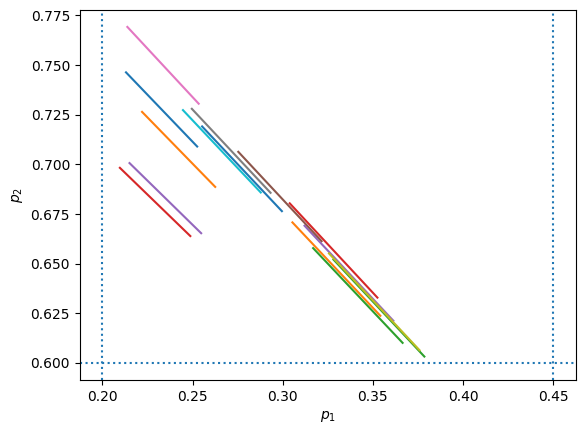

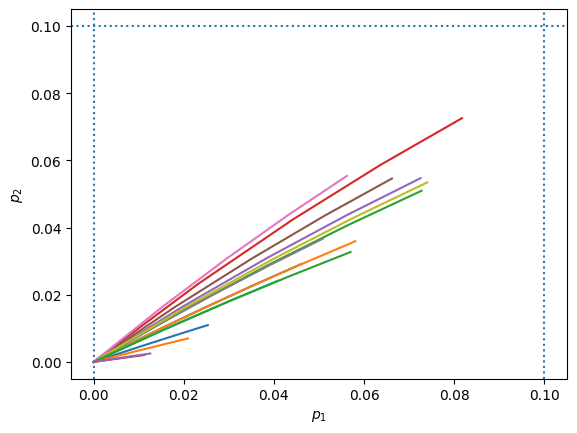

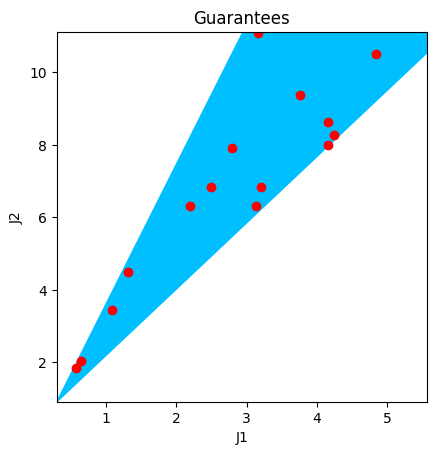

In [1]:

## constants
c = 1
delta = 1
# sigma 1
F_1_u_s = 5
F_1_u_h = 4
# sigma 2
p2_h = 0.6
p1_s = 0.45
p1_h = 0.2
F_2_p_1_s = 4.15
F_2_p_1_h = 4.1

# The following don't affect results
u_h = 10
u_s = 100

# define rest of the constants
# sigma 1
F_1_u_m = 0
F_1_u_l = 0.02
# sigma 2
p2_l = 0.1
p1_l = 0.1
p1_m = 0
F_2_p_1_m = 0
F_2_p_1_l = 0.01

# The following don't affect results
u_l = 1
u_m = 0


from pacti.contracts import PolyhedralIoContract
from pacti.terms.polyhedra import PolyhedralTermList, PolyhedralTerm
from pacti.utils import plots
from pacti.iocontract import Var
import numpy as np



top_level_objective = PolyhedralIoContract.from_strings(
    input_vars=[],
    output_vars=["d1", "d2"],
    assumptions=[],
    guarantees=[
        f"{(delta/c)*p1_h}*(1 + d1 + d2) <= d1",
        f"{(delta/c)*p1_s}*(1 + d1 + d2) >= d1",
        f"{(delta/c)*p2_h}*(1 + d1 + d2) <= d2",
    ]
    )



resource_sharing = PolyhedralIoContract.from_strings(
    input_vars=["J1","J2"],
    output_vars=["d1","d2"],
    assumptions=[],
    guarantees=[
    f"{F_1_u_h} J1 <= d1 <= {F_1_u_s} J1",
    f"{F_2_p_1_h} J2 <= d2 <= {F_2_p_1_s} J2"
    ],
    )

by_hand = PolyhedralIoContract.from_strings(
    input_vars=[],
    output_vars=["J1","J2"],
    assumptions=[],
    guarantees=[
    f"{-F_1_u_h*(p1_s - 1)}*J1 - {p1_s*(F_2_p_1_h)} * J2 <= {p1_s}",
    f"{-F_1_u_h*(1 - p1_h)}*J1 + {p1_h*(F_2_p_1_s)} * J2 <= {-p1_h}",
    f"{F_1_u_s*(p2_h)}*J1 - {(1-p2_h)*(F_2_p_1_h)} * J2 <= {-p2_h}",
    ],
    )



system_h_threshold = top_level_objective.quotient(resource_sharing)
print(f"== Missing spec\n{system_h_threshold}")
print(f"== Missing spec by hand\n{by_hand}")

_ = plots.plot_guarantees(contract=system_h_threshold,x_var=Var("J1"),y_var=Var("J2"),x_lims=(0,20),y_lims=(0,20),var_values={})
_ = plots.plot_guarantees(contract=system_h_threshold,x_var=Var("J1"),y_var=Var("J2"),x_lims=(0,20),y_lims=(0,20),var_values={})





top_level_objective_l = PolyhedralIoContract.from_strings(
    input_vars=[],
    output_vars=["d1", "d2"],
    assumptions=[],
    guarantees=[
        f"{(delta/c)*p1_l}*(1 + d1 + d2) >= d1",
        f"{(delta/c)*p2_l}*(1 + d1 + d2) >= d2"
    ]
    )

resource_sharing_l = PolyhedralIoContract.from_strings(
    input_vars=["J1","J2"],
    output_vars=["d1","d2"],
    assumptions=[],
    guarantees=[
    f"{F_1_u_m} J1 <= d1 <= {F_1_u_l} J1",
    f"{F_2_p_1_m} J2 <= d2 <= {F_2_p_1_l} J2"
    ],
    )

system_l_threshold = top_level_objective_l.quotient(resource_sharing_l)
print(f"== Missing spec\n{system_l_threshold}")

_ = plots.plot_guarantees(contract=system_l_threshold,x_var=Var("J1"),y_var=Var("J2"),x_lims=(0,20),y_lims=(0,20),var_values={})


# We merge the upper and lower requirements to obtain J parameters that would ensure that the system meets both thresholds
overall_system = system_l_threshold.merge(system_h_threshold)
print(f"== Overall spec\n{overall_system}")
_ = plots.plot_guarantees(contract=overall_system,x_var=Var("J1"),y_var=Var("J2"),x_lims=(1,4),y_lims=(3,7),var_values={})

import matplotlib.pyplot as plt

plt.close('all')



from scipy.optimize import fsolve

#%matplotlib inline


def f1(x):
    return (F_1_u_s - F_1_u_h)/(u_s - u_h) * (x - u_h) + F_1_u_h

def f2(x):
    return (F_2_p_1_s - F_2_p_1_h)/(p1_s - p1_h) * (x - p1_h) + F_2_p_1_h

def F1(p1,theta1,theta2,u):
    return p1*(1 + theta1*f1(u) + theta2*f2(p1)) - theta1*f1(u)

def F2(theta1,theta2,u,p1):
    #print(f"u is {u}. f1u is {f1(u)}/{F_1_u_h}/{F_1_u_s}. f2p1 is {f2(p1)}/{F_2_p_1_h}/{F_2_p_1_s}")
    return theta2*f2(p1) / (1 + theta1*f1(u) + theta2*f2(p1))

def getsol(theta1,theta2,u):
    a=fsolve(F1,1,args=(theta1,theta2,u))
    b=F2(theta1,theta2,u,a[0])
    return a[0],b
    
# setup a figure with requirements
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$p_1$")
ax.set_ylabel("$p_2$")
ax.axhline(y=p2_h,linestyle=":")
ax.axvline(x=p1_h,linestyle=":")
ax.axvline(x=p1_s,linestyle=":")


# given a value of parameters, return values to plot
def getplot(theta1,theta2):
    u_vals = np.linspace(u_h,u_s,15)
    #print(u_vals)
    data = [getsol(theta1,theta2,val) for val in u_vals]
    return list(map(list,zip(*data)))    


def getsatassignment(contract : PolyhedralIoContract):
    l,h = contract.get_variable_bounds('J2')
    #print(f"h/l {h}/{l}")
    p1val = np.random.random_sample() * (h - l) + l
    g : PolyhedralIoContract = contract.g.copy()
    term : PolyhedralTerm
    newg = []
    h2 = None
    l2 = None
    for term in g.terms:
        nt = term.substitute_variable(Var('J2'),PolyhedralTerm(variables={},constant=-p1val))
        #print(nt)
        try:
            a = nt.isolate_variable(var_to_isolate=Var('J1'))
        except:
            continue
        if nt.get_coefficient(var=Var('J1')) > 0:
            h2 = a.constant
        else:
            l2 = a.constant
    p2val = np.random.random_sample() * (h2 - l2) + l2
    #print(newg)
    return p2val, p1val

#theta1 = 5
#theta2 = 10

# get several samples of the parameters:
params_unfiltered = [getsatassignment(overall_system) for i in range(15)]
params = []
for i,param in enumerate(params_unfiltered):
    tl : PolyhedralTermList = overall_system.g
    if not tl.contains_behavior({Var('J1'): param[0], Var('J2'): param[1]}):
        print(f"Iteration {i} params {param}")
    else:
        params.append(param)


for el in params:
    xx,yy = getplot(*el)
    ax.plot(xx,yy,"-")


# now get lower side of the constraints:
def f1(x):
    return (F_1_u_l - F_1_u_m)/(u_l - u_m) * (x - u_m) + F_1_u_m

def f2(x):
    return (F_2_p_1_l - F_2_p_1_m)/(p1_l - p1_m) * (x - p1_m) + F_2_p_1_m

def F1(p1,theta1,theta2,u):
    return p1*(1 + theta1*f1(u) + theta2*f2(p1)) - theta1*f1(u)

def F2(theta1,theta2,u,p1):
    #print(f"u is {u}. f1u is {f1(u)}/{F_1_u_l}/{F_1_u_m}. f2p1 is {f2(p1)}/{F_2_p_1_l}/{F_2_p_1_m}")
    return theta2*f2(p1) / (1 + theta1*f1(u) + theta2*f2(p1))

def getsol(theta1,theta2,u):
    a=fsolve(F1,1,args=(theta1,theta2,u))
    b=F2(theta1,theta2,u,a[0])
    return a[0],b

def getplot(theta1,theta2):
    u_vals = np.linspace(u_m,u_l,5)
    #print(u_vals)
    data = [getsol(theta1,theta2,val) for val in u_vals]
    return list(map(list,zip(*data)))    


# setup a figure with requirements
figa = plt.figure()
ax = figa.add_subplot(1, 1, 1)
ax.set_xlabel("$p_1$")
ax.set_ylabel("$p_2$")


ax.axhline(y=p2_l,linestyle=":")
ax.axvline(x=p1_m,linestyle=":")
ax.axvline(x=p1_l,linestyle=":")



for el in params:
    xx,yy = getplot(*el)
    ax.plot(xx,yy,"-")




a = overall_system.get_variable_bounds('J1')
b = overall_system.get_variable_bounds('J2')

fig2 = plots.plot_guarantees(contract=overall_system,x_var=Var("J1"),y_var=Var("J2"),x_lims=a,y_lims=b,var_values={})
ax = fig2.get_axes()[0]
p1, p2 = list(map(list,zip(*params)))
ax.plot(p1,p2,'or')

#plt.show()

In [2]:
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})



fig2.set_size_inches(w=2, h=3)
fig2.savefig('sequential-params-sample.pgf',bbox_inches='tight')

fig.set_size_inches(w=2, h=3)
fig.savefig('sequential-operation-high.pgf',bbox_inches='tight')

figa.set_size_inches(w=2, h=3)
figa.savefig('sequential-operation-low.pgf',bbox_inches='tight')